In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import make_lupton_rgb
from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
from astropy.table import Table #if fits file is table, makes formatting easier

M31_data = Table.read('M31_Complete.fits')

print(M31_data.colnames) #magnitude in specific filter, heliocentric velocity

['RA', 'DEC', 'Xi', 'Eta', 'Vhel', 'Vhel error', 'Fe/H', 'F275W', 'F336W', 'F475W', 'F814W', 'F110W', 'F160W']


In [3]:
M31_ra_center = '00:42:44.30'
M31_dec_center = '+41:16:9.0'

coords = SkyCoord(M31_ra_center, M31_dec_center, unit=(u.hourangle, u.deg))
M31_rarad_center = coords.ra.wrap_at(180*u.deg).radian
M31_decrad_center = coords.dec.radian

print(M31_rarad_center)
print(M31_decrad_center)

0.18648115837037746
0.7202828378876265


In [4]:
ra = np.asarray(M31_data["RA"])
dec = np.asarray(M31_data["DEC"])
f475w = np.asarray(M31_data["F475W"])
f814w = np.asarray(M31_data["F814W"])
vhel = np.asarray(M31_data["Vhel"])
vhel_err = np.asarray(M31_data["Vhel error"])

In [5]:
coords = SkyCoord(ra, dec, unit=(u.deg, u.deg))

ra_rad_contam = coords.ra.wrap_at(180*u.deg).radian #from -180 to 180

dec_rad_contam = coords.dec.radian

outliers = np.where(vhel>200)[0]

f475w = np.delete(f475w, outliers)

f814w = np.delete(f814w, outliers)

vhel = np.delete(vhel, outliers)

ra_rad = np.delete(ra_rad_contam, outliers)
dec_rad = np.delete(dec_rad_contam, outliers)

vhel_err = np.delete(vhel_err, outliers)

In [6]:
print(len(ra_rad))
print(len(vhel))

9840
9840


(662.0, 703.0)

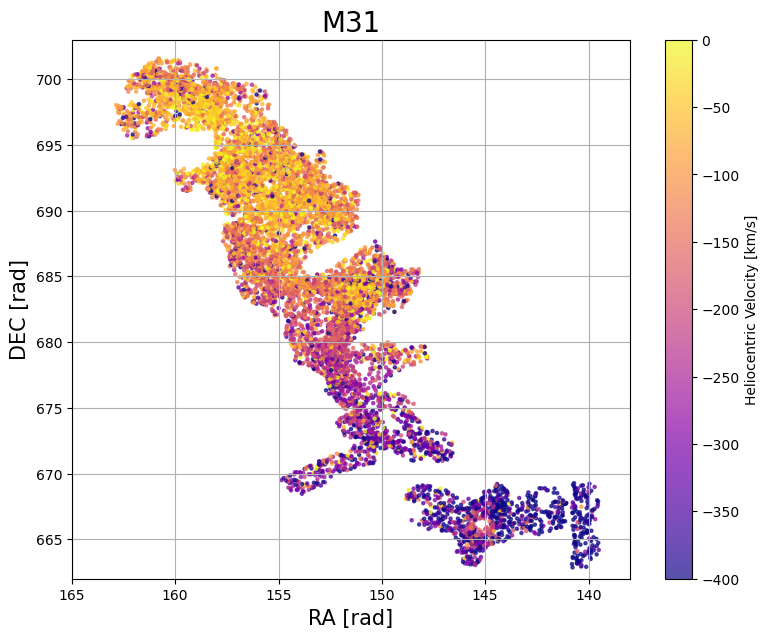

In [7]:
plt.figure(figsize=(9,7))
plt.title("M31", fontsize = 20)
plt.grid()

ra_kpc = np.tan(ra_rad)*770
dec_kpc = np.tan(dec_rad)*770

#color array needs to have same shape as x and y 
plt.scatter(ra_kpc, dec_kpc, c=vhel, s=5, cmap='plasma', vmin=-400, vmax=0, alpha = 0.7)
cbar = plt.colorbar()
cbar.set_label('Heliocentric Velocity [km/s]')
plt.xlabel("RA [rad]", fontsize =15)
plt.ylabel("DEC [rad]", fontsize =15)

#plt.axvline(x=0.18635)
#plt.axhline(y=0.7132)



plt.xlim(165, 138)

plt.ylim(662, 703)

#plt.xlim(0.185, 0.187)
#plt.ylim(0.713, 0.715)

In [8]:
len(ra_kpc)

9840

(23.0, 18.0)

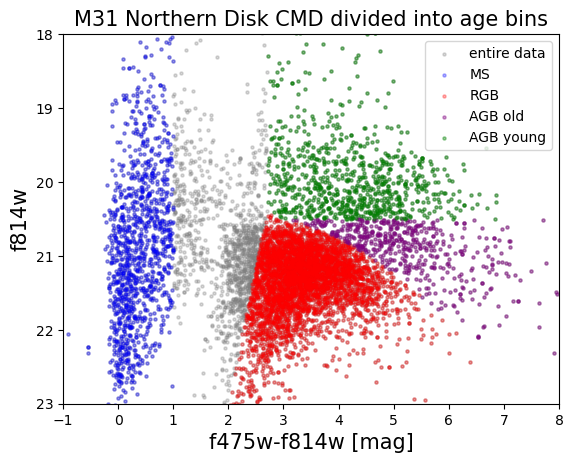

In [9]:
#MS
MS = np.where((f475w -f814w <=1) & (f475w -f814w >=-1))[0]

f475w_MS = f475w[MS] 
f814w_MS = f814w[MS]


#RGB
line1 = -2.6/0.7 * (f475w-f814w) + 30.42857142857143
a = 0.1
h = 2.1
k = 20.4
hyperbola = a*(f475w-f814w - h)**2. + k

RGB = np.where((f814w > line1) & (f814w > hyperbola))[0]

f475w_RGB = f475w[RGB]
f814w_RGB = f814w[RGB]


#AGB old
AGB_old = np.where((f814w < hyperbola) & (f814w > 20.5) & (f475w-f814w > 2.7))[0]

f475w_AGB_old = f475w[AGB_old]
f814w_AGB_old = f814w[AGB_old]

#AGB young
AGB_young = np.where((f814w < hyperbola) & (f814w < 20.5) & (f475w-f814w > 2.7))[0]

f475w_AGB_young = f475w[AGB_young]
f814w_AGB_young = f814w[AGB_young]


#plt.axes(aspect=1.5)

plt.scatter(f475w-f814w, f814w, s=5, alpha =0.3, c='gray', label='entire data')
plt.scatter(f475w_MS-f814w_MS, f814w_MS, s=5, alpha =0.3, label='MS', c='blue')

plt.scatter(f475w_RGB - f814w_RGB, f814w_RGB, s=5, alpha=0.3, label='RGB', c='red')

plt.scatter(f475w_AGB_old-f814w_AGB_old, f814w_AGB_old, s=5, alpha=0.4, label='AGB old', c='purple')

plt.scatter(f475w_AGB_young-f814w_AGB_young, f814w_AGB_young, s=5, alpha=0.4, label='AGB young', c='green')

plt.legend(loc='upper right')
plt.title("M31 Northern Disk CMD divided into age bins", fontsize = 15)
plt.xlabel("f475w-f814w [mag]", fontsize=15)
plt.ylabel("f814w", fontsize=15)

plt.xlim(-1,8)
plt.ylim(23,18)


In [10]:
def derek_get_dispersion(index, radius, std=False):
    ra_code = ra_rad[index]
    dec_code = dec_rad[index]
    vel_code = vhel[index]
    verr_code = vhel_err[index]

    v_dis = []
    ra_dis = []
    dec_dis = []
    vhel_dis = []
    for i in range(len(ra_code)):
        Xc = ra_code[i]
        Yc = dec_code[i]
        vhel_circle = vel_code[i]
        r = (np.sin(Yc) * np.sin(dec_code) + np.cos(Yc) * np.cos(dec_code) * np.cos(np.abs(Xc - ra_code)))#distance of all points to (x and y)
        ang = np.arccos(r)
        
        in_circle = np.where(ang < radius)[0]
        if len(in_circle) > 15:
            weights = 1/(verr_code[in_circle])
                
            xbar = np.average(vel_code[in_circle], weights = weights)

            numerator = np.sum(weights*(vel_code[in_circle] - xbar)**2)
            denominator = (len(in_circle)-1)/len(in_circle)*np.sum(weights)
                
            dispersion = np.sqrt(numerator/denominator)
            #vhel [stars_in_circle] the velocity of stars in my circle.
            v_dis.append(dispersion)
            ra_dis.append(Xc)
            dec_dis.append(Yc)
            vhel_dis.append(vhel_circle)
            
            
    return np.asarray(ra_dis), np.asarray(dec_dis), np.asarray(v_dis), np.asarray(vhel_dis)

/var/folders/rf/qb1kdfd52kdgjzt3dzgyx_lw0000gn/T/ipykernel_28228/3758019489.py:16: RuntimeWarning: invalid value encountered in arccos
  ang = np.arccos(r)


(662.0, 703.0)

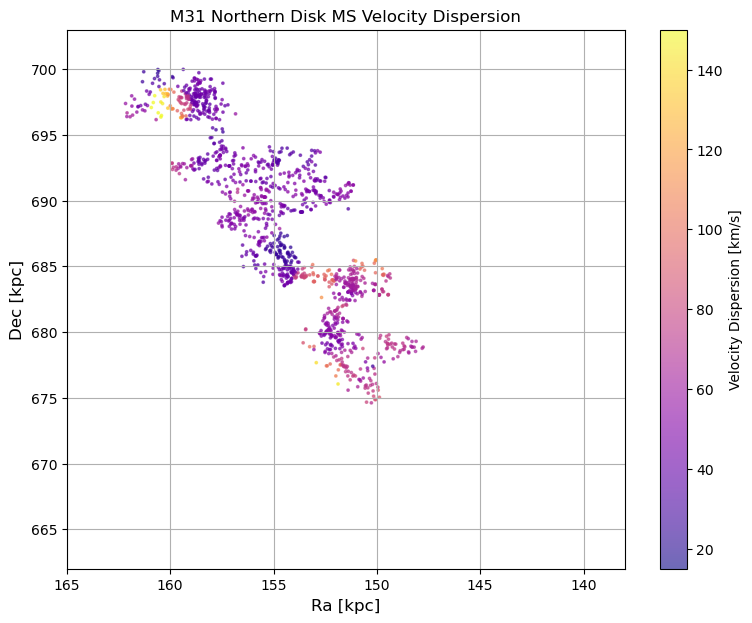

In [11]:
#RGB Dispersion Graph

ra_disp_MS, dec_disp_MS, vel_disp_MS, vhel_disp_MS = derek_get_dispersion(MS, 200*4.84814e-6)

ra_kpc_MS = np.tan(ra_disp_MS)*770
dec_kpc_MS = np.tan(dec_disp_MS)*770

plt.figure(figsize=(9,7))
plt.scatter(ra_kpc_MS, dec_kpc_MS, s=3, alpha=0.6, c=vel_disp_MS, cmap='plasma', vmin=15, vmax=150)
plt.grid()
plt.xlabel("Ra [kpc]", fontsize=12)
plt.ylabel("Dec [kpc]", fontsize=12)
plt.title("M31 Northern Disk MS Velocity Dispersion", fontsize=12)
cbar = plt.colorbar()
cbar.set_label('Velocity Dispersion [km/s]')



plt.xlim(165, 138)
plt.ylim(662, 703)

/var/folders/rf/qb1kdfd52kdgjzt3dzgyx_lw0000gn/T/ipykernel_28228/3758019489.py:16: RuntimeWarning: invalid value encountered in arccos
  ang = np.arccos(r)


199.4160728775615
56.521821311994685


(662.0, 703.0)

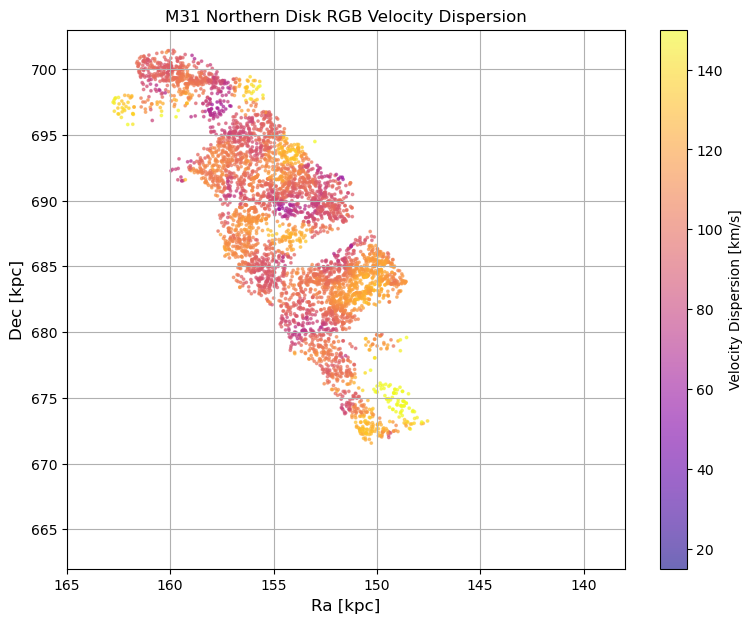

In [12]:
#RGB Dispersion Graph

ra_disp_RGB, dec_disp_RGB, vel_disp_RGB, vhel_disp_RGB = derek_get_dispersion(RGB, 200*4.84814e-6)

ra_kpc_RGB = np.tan(ra_disp_RGB)*770
dec_kpc_RGB = np.tan(dec_disp_RGB)*770

plt.figure(figsize=(9,7))
plt.scatter(ra_kpc_RGB, dec_kpc_RGB, s=3, alpha=0.6, c=vel_disp_RGB, cmap='plasma', vmin=15, vmax=150)
plt.grid()
plt.xlabel("Ra [kpc]", fontsize=12)
plt.ylabel("Dec [kpc]", fontsize=12)
plt.title("M31 Northern Disk RGB Velocity Dispersion", fontsize=12)
cbar = plt.colorbar()
cbar.set_label('Velocity Dispersion [km/s]')

print(np.max(vel_disp_RGB))
print(np.min(vel_disp_RGB))

plt.xlim(165, 138)
plt.ylim(662, 703)


162.660314936508
39.294937945210464


/var/folders/rf/qb1kdfd52kdgjzt3dzgyx_lw0000gn/T/ipykernel_28228/3758019489.py:16: RuntimeWarning: invalid value encountered in arccos
  ang = np.arccos(r)


(662.0, 703.0)

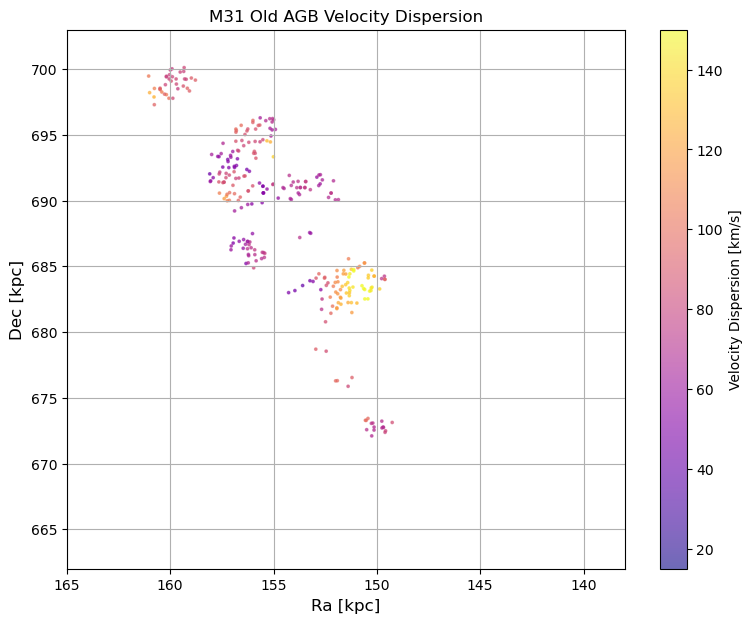

In [13]:
#AGB Old Dispersion Graph

ra_disp_AGB_old, dec_disp_AGB_old, vel_disp_AGB_old, vhel_disp_AGB_old = derek_get_dispersion(AGB_old, 200*4.84814e-6)

ra_kpc_AGB_old = np.tan(ra_disp_AGB_old)*770
dec_kpc_AGB_old = np.tan(dec_disp_AGB_old)*770


plt.figure(figsize=(9,7))
plt.scatter(ra_kpc_AGB_old, dec_kpc_AGB_old, s=3, alpha=0.6, c=vel_disp_AGB_old, cmap='plasma', vmin=15, vmax=150)
plt.grid()
plt.xlabel("Ra [kpc]", fontsize=12)
plt.ylabel("Dec [kpc]", fontsize=12)
plt.title("M31 Old AGB Velocity Dispersion", fontsize=12)
cbar = plt.colorbar()
cbar.set_label('Velocity Dispersion [km/s]')

print(np.max(vel_disp_AGB_old))
print(np.min(vel_disp_AGB_old))

plt.xlim(165, 138)
plt.ylim(662, 703)

160.99669197958494
22.760950837024357


/var/folders/rf/qb1kdfd52kdgjzt3dzgyx_lw0000gn/T/ipykernel_28228/3758019489.py:16: RuntimeWarning: invalid value encountered in arccos
  ang = np.arccos(r)


(662.0, 703.0)

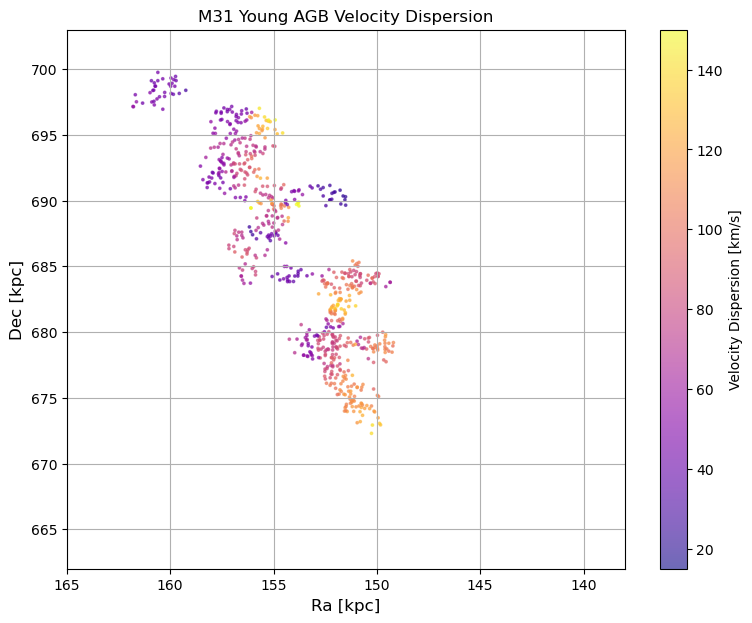

In [14]:
#AGB Young Dispersion Graph

ra_disp_AGB_young, dec_disp_AGB_young, vel_disp_AGB_young, vhel_disp_AGB_young = derek_get_dispersion(AGB_young, 200*4.84814e-6)

ra_kpc_AGB_young = np.tan(ra_disp_AGB_young)*770
dec_kpc_AGB_young = np.tan(dec_disp_AGB_young)*770

plt.figure(figsize=(9,7))
plt.scatter(ra_kpc_AGB_young, dec_kpc_AGB_young, s=3, alpha=0.6, c=vel_disp_AGB_young, cmap='plasma', vmin=15, vmax=150)
plt.grid()
plt.xlabel("Ra [kpc]", fontsize=12)
plt.ylabel("Dec [kpc]", fontsize=12)
plt.title("M31 Young AGB Velocity Dispersion", fontsize=12)
cbar = plt.colorbar()
cbar.set_label('Velocity Dispersion [km/s]')

print(np.max(vel_disp_AGB_young))
print(np.min(vel_disp_AGB_young))

plt.xlim(165, 138)
plt.ylim(662, 703)

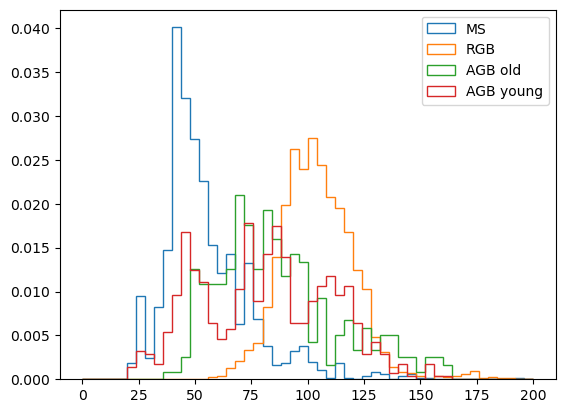

In [15]:
plt.hist(vel_disp_MS, bins=50, histtype='step', density='true', range=(0,200), label='MS')
plt.hist(vel_disp_RGB, bins=50, histtype='step', density='true', range=(0,200), label='RGB')
plt.hist(vel_disp_AGB_old, bins=50, histtype='step', density='true', range=(0,200), label='AGB old')
plt.hist(vel_disp_AGB_young, bins=50, histtype='step', density='true', range=(0,200), label='AGB young')
plt.legend(loc='upper right')

In [16]:
len(ra_rad)

9840

55.78458861416471
104.40108079155027
81.37793877609523
87.04755855578198
1243
702
298
4521
[0.03 4.   2.   0.4 ]
81.37793877609523
87.04755855578198
104.40108079155027


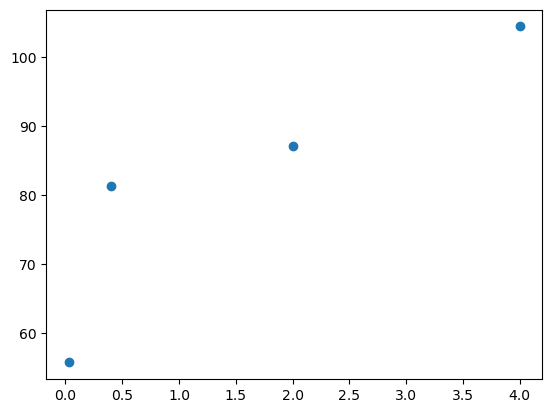

In [17]:
arr = [np.mean(vel_disp_MS), np.mean(vel_disp_RGB), np.mean(vel_disp_AGB_old), np.mean(vel_disp_AGB_young)]
ages = [0.03, 4, 2, 0.4]

plt.scatter(ages, arr)
#plt.xlim(-0.5, 7)
#plt.ylim(0, 120)
print(np.mean(vel_disp_MS))
print(np.mean(vel_disp_RGB))
print(np.mean(vel_disp_AGB_young))
print(np.mean(vel_disp_AGB_old))
print(len(vel_disp_MS))

print(len(vel_disp_AGB_young))
print(len(vel_disp_AGB_old))
print(len(vel_disp_RGB))

arr = np.asarray(arr)
ages = np.asarray(ages)
print(ages)

np.save("M31_north_arr", arr)
np.save("M31_north_ages", ages)

print(np.mean(vel_disp_AGB_young))
print(np.mean(vel_disp_AGB_old))
print(np.mean(vel_disp_RGB))


In [18]:
all_stars = list(range(0, len(ra_rad)))

print(len(all_stars))

ra_all, dec_all, vel_disp_all, vhel_all = derek_get_dispersion(all_stars, 200*4.84814e-6)


9840


/var/folders/rf/qb1kdfd52kdgjzt3dzgyx_lw0000gn/T/ipykernel_28228/3758019489.py:16: RuntimeWarning: invalid value encountered in arccos
  ang = np.arccos(r)


In [19]:
star_dist = []

for i in range(len(ra_all)):
    centerX = M31_rarad_center
    centerY = M31_decrad_center
    
    delta_dist = (np.sin(centerY))*(np.sin(dec_rad))+(np.cos(centerY))*(np.cos(dec_rad))*(np.cos(np.abs(centerX-ra_rad)))
    dist = np.arccos(delta_dist)
    
    star_dist.append(dist[i])

print(len(star_dist))
print("min:", np.min(star_dist))
print("max:", np.max(star_dist))

star_dist = np.asarray(star_dist)

9830
min: 0.0025464928665194096
max: 0.7398208885898652


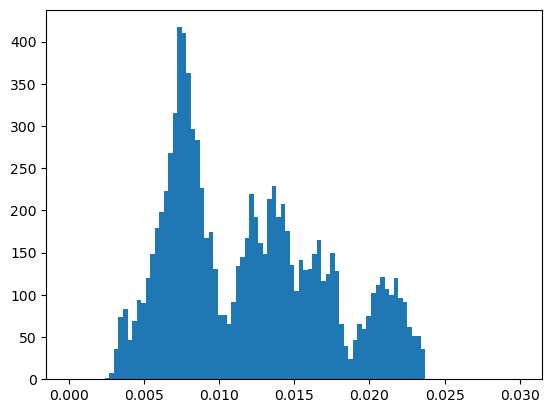

In [20]:
star_dist_hist = plt.hist(star_dist, bins=100, range=(0,0.03))

Text(0.5, 1.0, 'M31 Northern Disk Velocity Dispersion Histogram')

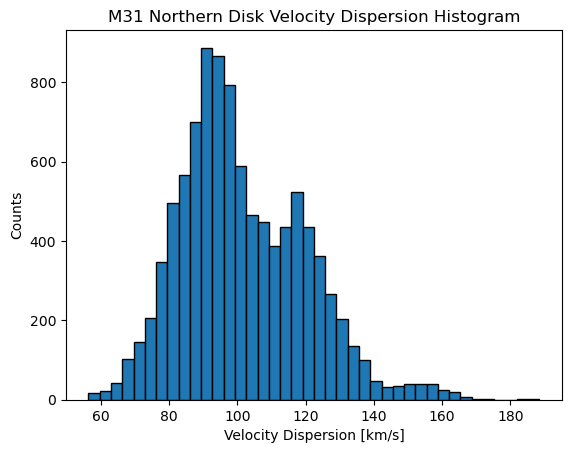

In [21]:
plt.hist(vel_disp_all, bins=40, ec='k')
plt.ylabel("Counts")
plt.xlabel("Velocity Dispersion [km/s]")
plt.title("M31 Northern Disk Velocity Dispersion Histogram")

(array([1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        4.000e+00, 4.000e+00, 2.000e+00, 9.000e+00, 1.900e+01, 2.300e+01,
        5.700e+01, 6.700e+01, 7.500e+01, 9.700e+01, 8.800e+01, 1.450e+02,
        1.510e+02, 2.030e+02, 2.090e+02, 2.510e+02, 3.070e+02, 3.220e+02,
        3.980e+02, 5.640e+02, 6.570e+02, 7.600e+02, 9.570e+02, 1.117e+03,
        1.138e+03, 1.035e+03, 6.580e+02, 3.270e+02, 1.070e+02, 5.800e+01,
        1.400e+01, 7.000e+00, 3.000e+00, 4.000e+00]),
 array([-925.5248456 , -897.87486771, -870.22488983, -842.57491194,
        -814.92493405, -787.27495617, -759.62497828, -731.97500039,
        -704.32502251, -676.67504462, -649.02506673, -621.37508885,
        -593.72511096, -566.07513307, -538.42515519, -510.7751773 ,
        -483.12519941, -455.47522153, -427.82524364, -400.17526575,
        -372.52528787, -344.87530998, -317.22533209, -289.57535421,
        -261.92537632, -234.27539843, -206.62542055, -178.97544266,
        -151.32546477, -12

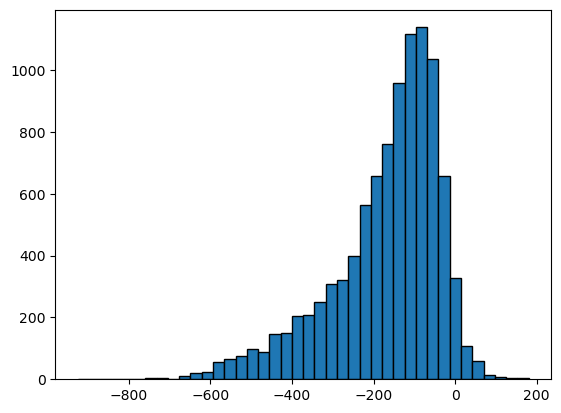

In [22]:
plt.hist(vhel, bins=40, ec='k')

In [23]:
np.max(star_dist)

0.7398208885898652

In [24]:
rings = np.zeros(60)
print(rings)

rings_distance = np.zeros(60)

increment = 0.0005

#all_stars = list(range(0, len(ra_rad_M32)))

#ra_all, dec_all, vel_disp_all = derek_get_dispersion(all_stars, 200*4.8481e-6)

ring0 = []
ring1 = []
ring2 = []
ring3 = []
ring4 = []
ring5 = []
ring6 = []
ring7 = []
ring8 = []
ring9 = []
ring10 = []
ring11 = []
ring12 = []
ring13 = []
ring14 = []
ring15 = []
ring16 = []
ring17 = []
ring18 = []
ring19 = []
ring20 = []
ring21 = []
ring22 = []
ring23 = []
ring24 = []
ring25 = []
ring26 = []
ring27 = []
ring28 = []
ring29 = []
ring30 = []
ring31 = []
ring32 = []
ring33 = []
ring34 = []
ring35 = []
ring36 = []
ring37 = []
ring38 = []
ring39 = []
ring40 = []
ring41 = []
ring42 = []
ring43 = []
ring44 = []
ring45 = []
ring46 = []
ring47 = []
ring48 = []
ring49 = []
ring50 = []
ring51 = []
ring52 = []
ring53 = []
ring54 = []
ring55 = []
ring56 = []
ring57 = []
ring58 = []
ring59 = []



def put_in_ring(index_number, ring_number, ring_name):
    if index_number == ring_number:
        ring_name.append(in_ring)


for x in range(60):
    in_ring = np.where((increment*(x) < star_dist) & (star_dist < increment*(x+1)))[0]
    print(x)
    rings[x] = np.nanmean(np.asarray(vel_disp_all)[in_ring])
    rings_distance[x] = (increment*(x) + increment*(x+1))/2
    #print(x)
    put_in_ring(x, 0, ring0)
    put_in_ring(x, 1, ring1)
    put_in_ring(x, 2, ring2)
    put_in_ring(x, 3, ring3)
    put_in_ring(x, 4, ring4)
    put_in_ring(x, 5, ring5)
    put_in_ring(x, 6, ring6)
    put_in_ring(x, 7, ring7)
    put_in_ring(x, 8, ring8)
    put_in_ring(x, 9, ring9)
    put_in_ring(x, 10, ring10)
    put_in_ring(x, 11, ring11)
    put_in_ring(x, 12, ring12)
    put_in_ring(x, 13, ring13)
    put_in_ring(x, 14, ring14)
    put_in_ring(x, 15, ring15)
    put_in_ring(x, 16, ring16)
    put_in_ring(x, 17, ring17)
    put_in_ring(x, 18, ring18)
    put_in_ring(x, 19, ring19)
    put_in_ring(x, 20, ring20)
    put_in_ring(x, 21, ring21)
    put_in_ring(x, 22, ring22)
    put_in_ring(x, 23, ring23)
    put_in_ring(x, 24, ring24)
    put_in_ring(x, 25, ring25)
    put_in_ring(x, 26, ring26)
    put_in_ring(x, 27, ring27)
    put_in_ring(x, 28, ring28)
    put_in_ring(x, 29, ring29)
    put_in_ring(x, 30, ring30)
    put_in_ring(x, 31, ring31)
    put_in_ring(x, 32, ring32)
    put_in_ring(x, 33, ring33)
    put_in_ring(x, 34, ring34)
    put_in_ring(x, 35, ring35)
    put_in_ring(x, 36, ring36)
    put_in_ring(x, 37, ring37)
    put_in_ring(x, 38, ring38)
    put_in_ring(x, 39, ring39)
    put_in_ring(x, 40, ring40)
    put_in_ring(x, 41, ring41)
    put_in_ring(x, 42, ring42)
    put_in_ring(x, 43, ring43)
    put_in_ring(x, 44, ring44)
    put_in_ring(x, 45, ring45)
    put_in_ring(x, 46, ring46)
    put_in_ring(x, 47, ring47)
    put_in_ring(x, 48, ring48)
    put_in_ring(x, 49, ring49)
    put_in_ring(x, 50, ring50)
    put_in_ring(x, 51, ring51)
    put_in_ring(x, 52, ring52)
    put_in_ring(x, 53, ring53)
    put_in_ring(x, 54, ring54)
    put_in_ring(x, 55, ring55)
    put_in_ring(x, 56, ring56)
    put_in_ring(x, 57, ring57)
    put_in_ring(x, 58, ring58)
    put_in_ring(x, 59, ring59)
    

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


/var/folders/rf/qb1kdfd52kdgjzt3dzgyx_lw0000gn/T/ipykernel_28228/141656546.py:83: RuntimeWarning: Mean of empty slice
  rings[x] = np.nanmean(np.asarray(vel_disp_all)[in_ring])


60
60
0.19250000401041675
22.914260583165124


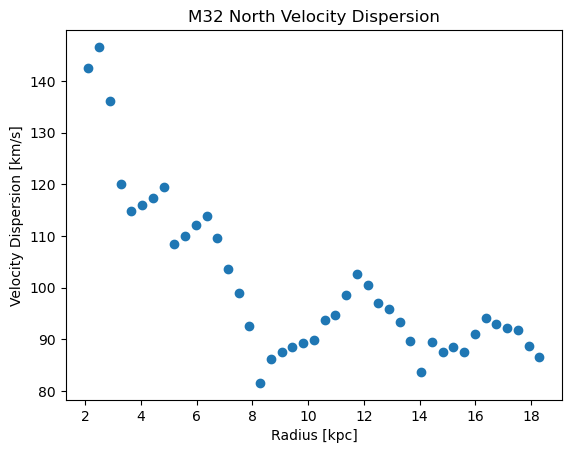

In [25]:
rings_distance_kpc = np.tan(rings_distance) * 770

print(len(rings_distance_kpc))

print(len(rings))

plt.scatter(rings_distance_kpc, rings)
plt.title("M32 North Velocity Dispersion")
plt.xlabel("Radius [kpc]")
plt.ylabel("Velocity Dispersion [km/s]")


print(np.min(rings_distance_kpc))
print(np.max(rings_distance_kpc))

In [26]:
rings_north = rings

rings_distance_kpc_north = rings_distance_kpc


In [27]:
np.save("M31_North_Rings", rings_north)
np.save("M31_North_Rings_distance", rings_distance_kpc_north)

In [28]:
#print(ring55)
#print(ring56)
#print(ring57)
#print(ring58)
rings[54]


nan

(662.0, 703.0)

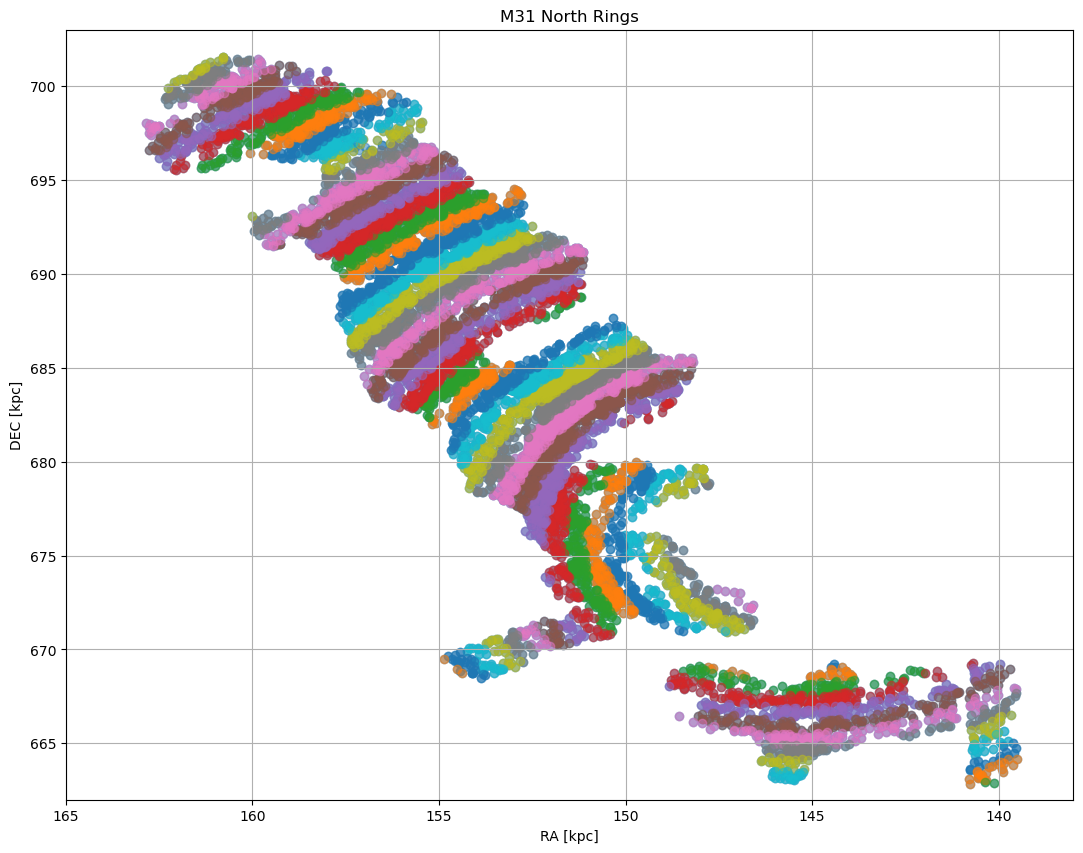

In [29]:
#converting ra and dec to kpc
ra_kpc = np.tan(ra_rad)*770
dec_kpc = np.tan(dec_rad)*770

plt.figure(figsize=(13,10))
#plt.axes(aspect='equal')
plt.scatter(ra_kpc, dec_kpc, alpha=0.5)#, c=vhel, cmap='plasma', vmin= -600, vmax=0)
plt.grid()
plt.xlabel("RA [kpc]")
plt.ylabel("DEC [kpc]")
plt.title("M31 North Rings")




plt.xlim(146.8, 133.8)


plt.ylim(657.5,670)
#plt.ylim(0.7069, 0.716)

plt.scatter(ra_kpc[ring0], dec_kpc[ring0], alpha=0.5)
plt.scatter(ra_kpc[ring1], dec_kpc[ring1], alpha=0.5)#c='red', )#, alpha= 0.7)#, c=vhel, cmap='plasma', vmin= -600, vmax=0)
plt.scatter(ra_kpc[ring2], dec_kpc[ring2], alpha=0.5)
plt.scatter(ra_kpc[ring3], dec_kpc[ring3], alpha=0.5)
plt.scatter(ra_kpc[ring4], dec_kpc[ring4], alpha=0.5)
plt.scatter(ra_kpc[ring5], dec_kpc[ring5], alpha=0.5)
plt.scatter(ra_kpc[ring6], dec_kpc[ring6], alpha=0.5)
plt.scatter(ra_kpc[ring7], dec_kpc[ring7], alpha=0.5)
plt.scatter(ra_kpc[ring8], dec_kpc[ring8], alpha=0.5)
plt.scatter(ra_kpc[ring9], dec_kpc[ring9], alpha=0.5)
plt.scatter(ra_kpc[ring10], dec_kpc[ring10], alpha=0.5)
plt.scatter(ra_kpc[ring11], dec_kpc[ring11], alpha=0.5)
plt.scatter(ra_kpc[ring12], dec_kpc[ring12], alpha=0.5)
plt.scatter(ra_kpc[ring13], dec_kpc[ring13], alpha=0.5)
plt.scatter(ra_kpc[ring14], dec_kpc[ring14], alpha=0.5)
plt.scatter(ra_kpc[ring15], dec_kpc[ring15], alpha=0.5)
plt.scatter(ra_kpc[ring16], dec_kpc[ring16], alpha=0.5)
plt.scatter(ra_kpc[ring17], dec_kpc[ring17], alpha=0.5)
plt.scatter(ra_kpc[ring18], dec_kpc[ring18], alpha=0.5)
plt.scatter(ra_kpc[ring19], dec_kpc[ring19], alpha=0.5)
plt.scatter(ra_kpc[ring20], dec_kpc[ring20], alpha=0.5)
plt.scatter(ra_kpc[ring21], dec_kpc[ring21], alpha=0.5)
plt.scatter(ra_kpc[ring22], dec_kpc[ring22], alpha=0.5)
plt.scatter(ra_kpc[ring23], dec_kpc[ring23], alpha=0.5)
plt.scatter(ra_kpc[ring24], dec_kpc[ring24], alpha=0.5)
plt.scatter(ra_kpc[ring25], dec_kpc[ring25], alpha=0.5)
plt.scatter(ra_kpc[ring26], dec_kpc[ring26], alpha=0.5)
plt.scatter(ra_kpc[ring27], dec_kpc[ring27], alpha=0.5)
plt.scatter(ra_kpc[ring28], dec_kpc[ring28], alpha=0.5)
plt.scatter(ra_kpc[ring29], dec_kpc[ring29], alpha=0.5)
plt.scatter(ra_kpc[ring30], dec_kpc[ring30], alpha=0.5)
plt.scatter(ra_kpc[ring31], dec_kpc[ring31], alpha=0.5)
plt.scatter(ra_kpc[ring32], dec_kpc[ring32], alpha=0.5)
plt.scatter(ra_kpc[ring33], dec_kpc[ring33], alpha=0.5)
plt.scatter(ra_kpc[ring34], dec_kpc[ring34], alpha=0.5)
plt.scatter(ra_kpc[ring35], dec_kpc[ring35], alpha=0.5)
plt.scatter(ra_kpc[ring36], dec_kpc[ring36], alpha=0.5)
plt.scatter(ra_kpc[ring37], dec_kpc[ring37], alpha=0.5)
plt.scatter(ra_kpc[ring38], dec_kpc[ring38], alpha=0.5)
plt.scatter(ra_kpc[ring39], dec_kpc[ring39], alpha=0.5)
plt.scatter(ra_kpc[ring40], dec_kpc[ring40], alpha=0.5)
plt.scatter(ra_kpc[ring41], dec_kpc[ring41], alpha=0.5)
plt.scatter(ra_kpc[ring42], dec_kpc[ring42], alpha=0.5)
plt.scatter(ra_kpc[ring43], dec_kpc[ring43], alpha=0.5)
plt.scatter(ra_kpc[ring44], dec_kpc[ring44], alpha=0.5)
plt.scatter(ra_kpc[ring45], dec_kpc[ring45], alpha=0.5)
plt.scatter(ra_kpc[ring46], dec_kpc[ring46], alpha=0.5)
plt.scatter(ra_kpc[ring47], dec_kpc[ring47], alpha=0.5)
plt.scatter(ra_kpc[ring48], dec_kpc[ring48], alpha=0.5)
plt.scatter(ra_kpc[ring49], dec_kpc[ring49], alpha=0.5)
plt.scatter(ra_kpc[ring50], dec_kpc[ring50], alpha=0.5)
plt.scatter(ra_kpc[ring51], dec_kpc[ring51], alpha=0.5)
plt.scatter(ra_kpc[ring52], dec_kpc[ring52], alpha=0.5)
plt.scatter(ra_kpc[ring53], dec_kpc[ring53], alpha=0.5)
plt.scatter(ra_kpc[ring54], dec_kpc[ring54], alpha=0.5)
plt.scatter(ra_kpc[ring55], dec_kpc[ring55], alpha=0.5)
plt.scatter(ra_kpc[ring56], dec_kpc[ring56], alpha=0.5)
plt.scatter(ra_kpc[ring57], dec_kpc[ring57], alpha=0.5)
plt.scatter(ra_kpc[ring58], dec_kpc[ring58], alpha=0.5)
plt.scatter(ra_kpc[ring59], dec_kpc[ring59], alpha=0.5)

#

plt.xlim(165, 138)

plt.ylim(662, 703)

#plt.scatter(ra_kpc)



188.5197889736504
56.31236693105846


(662.0, 703.0)

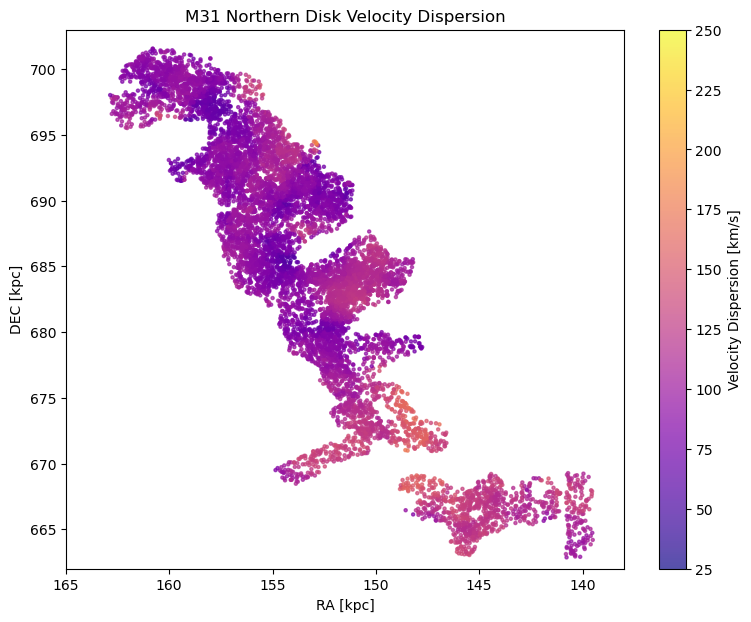

In [30]:
ra_all_kpc_north = np.tan(ra_all)*770
dec_all_kpc_north = np.tan(dec_all)*770

print(np.max(vel_disp_all))
print(np.min(vel_disp_all))

plt.figure(figsize=(9,7))
plt.scatter(ra_all_kpc_north, dec_all_kpc_north, alpha = 0.7, c=vel_disp_all, s=5, cmap='plasma', vmin=25, vmax=250)
cbar = plt.colorbar()
cbar.set_label('Velocity Dispersion [km/s]')
plt.xlabel("RA [kpc]", fontsize =10)
plt.ylabel("DEC [kpc]", fontsize =10)
plt.title("M31 Northern Disk Velocity Dispersion")
#plt.axvline(x=0.18635)
#plt.axhline(y=0.7132)




plt.xlim(165, 138)

plt.ylim(662, 703)
#plt.xlim(165, 138)

#plt.ylim(662, 703)




In [31]:
ra_all_kpc_north

array([145.58626876, 145.98857962, 145.31346493, ..., 156.53931397,
       156.54211286, 157.36936102])

In [32]:
print(len(ra_kpc))
print(len(ra_all))
print(len(vhel_all))

9840
9830
9830


In [33]:
np.save("M31_north_ra", ra_all)
np.save("M31_north_dec", dec_all)
np.save("M31_north_vel_disp", vel_disp_all)
np.save("M31_north_vhel", vhel_all)
np.save("M31_north_vhel_err", vhel_err)


In [34]:
vhel_all

array([-432.07834005, -308.0910697 , -287.89243317, ..., -139.68892145,
        -60.83350039,  -64.05079374])